In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import bokeh

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [4]:
nfl_data = {}
wr_filter = ['Year', 'Player', 'Tm', 'Age', 'Pos', 'Games G', 'Games GS', 'Receiving Tgt', 'Receiving Rec', 
             'Receiving Yds', 'Receiving Y/R', 'Receiving TD', 'Receiving Lng', 'Receiving R/G', 'Receiving Y/G', 
             'Receiving Ctch%', 'Fmb']

In [5]:
pro_bowl = {2013 : ['']}

In [6]:
def add_pro_bowl(data, year):
    if data.Player in pro_bowl[year]:
        return 1
    else:
        return 0

In [7]:
for i in range(2013,2019):
    rr_data = pd.read_csv('Data/nfl-{}-rr.csv'.format(i))
    rr_data['Year'] = i
    filtered_data = rr_data[wr_filter]
    ready_data = filtered_data.set_index(['Year', 'Player'])
    #Add Pro Bowl
    nfl_data[i] = ready_data

In [8]:
nfl_data[2018].head()

Tm  Age Pos  Games G  Games GS  Receiving Tgt  \
Year Player                                                                
2018 Saquon Barkley       NYG   21  RB       16        16            121   
     Ezekiel Elliott      DAL   23  RB       15        15             95   
     Christian McCaffrey  CAR   22  RB       16        16            124   
     Todd Gurley          LAR   24  RB       14        14             81   
     Julio Jones          ATL   29  WR       16        16            170   

                          Receiving Rec  Receiving Yds  Receiving Y/R  \
Year Player                                                             
2018 Saquon Barkley                  91            721            7.9   
     Ezekiel Elliott                 77            567            7.4   
     Christian McCaffrey            107            867            8.1   
     Todd Gurley                     59            580            9.8   
     Julio Jones                    113           1677           14.8   

                          Receiving TD  Receiving Lng  Receiving R/G  \
Year Player                                                            
2018 Saquon Barkley                  4             57            5.7   
     Ezekiel Elliott                 3             38            5.1   
     Christian McCaffrey             6             38            6.7   
     Todd Gurley                     4             56            4.2   
     Julio Jones                     8             58            7.1   

                          Receiving Y/G Receiving Ctch%  Fmb  
Year Player                                                   
2018 Saquon Barkley                45.1          75.20%    0  
     Ezekiel Elliott               37.8          81.10%    6  
     Christian McCaffrey           54.2          86.30%    4  
     Todd Gurley                   41.4          72.80%    1  
     Julio Jones                  104.8          66.50%    2

In [9]:
nfl_data[2018].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 557 entries, (2018, Saquon Barkley) to (2018, Jonathan Williams)
Data columns (total 15 columns):
Tm                 557 non-null object
Age                557 non-null int64
Pos                418 non-null object
Games G            557 non-null int64
Games GS           557 non-null int64
Receiving Tgt      557 non-null int64
Receiving Rec      557 non-null int64
Receiving Yds      557 non-null int64
Receiving Y/R      490 non-null float64
Receiving TD       557 non-null int64
Receiving Lng      557 non-null int64
Receiving R/G      557 non-null float64
Receiving Y/G      557 non-null float64
Receiving Ctch%    557 non-null object
Fmb                557 non-null int64
dtypes: float64(3), int64(9), object(3)
memory usage: 71.3+ KB


In [10]:
nfl = nfl_data[2013]
for i in range(2014,2019):
    nfl = pd.concat([nfl, nfl_data[i]])

## Filtering to WRs

In [11]:
nfl.Pos.astype('category').cat.categories

Index([u'C', u'CB', u'DE', u'DT', u'DT/ldt', u'FB', u'FB/rb', u'FB/wr', u'FS',
       u'K', u'LCB', u'LDT/rdt', u'LG', u'LT', u'NT', u'P', u'QB', u'QB/wr',
       u'RB', u'RB/te', u'TE', u'TE/wr', u'WR', u'c', u'cb', u'cb/rcb', u'db',
       u'db/s/ss', u'db/ss', u'de/NT', u'dt/LDT/rdt', u'dt/T', u'fb', u'fb/RB',
       u'fb/TE', u'fb/TE/wr', u'fb/WR', u'fb/rb', u'fb/rb/te', u'fb/rb/wr',
       u'fb/tb/TE', u'fb/te', u'fb/te/wr', u'fb/wr', u'fs', u'fs/SS', u'fs/ss',
       u'k/wr', u'lcb', u'lcb/wr', u'lg/RT/t', u'mlb', u'p', u'p/TE', u'qb',
       u'qb/RB', u'rb', u'rb/TE', u'rb/WR', u'rb/te', u'rb/te/wr', u'rb/wr',
       u'rt', u'rt/t/te', u's', u's/ss', u'ss', u't/te', u'tb/TE', u'tb/te',
       u'te', u'te/wr', u'wr'],
      dtype='object')

In [12]:
def position_fix(data):
    if data.Pos == 'wr' or data.Pos == 'WR': 
        return 'WR'

In [13]:
nfl.Pos = nfl.apply(position_fix, axis = 1)
wr = nfl[nfl.Pos == 'WR']

## Cleaning Data

In [14]:
wr['Receiving Ctch%'] = wr['Receiving Ctch%'].str[:-1].astype('float64')

In [15]:
wr = wr.fillna(0)
wr = wr.drop(['Tm', 'Pos'], axis = 1)

In [16]:
wr.head()

Age  Games G  Games GS  Receiving Tgt  Receiving Rec  \
Year Player                                                                   
2013 Josh Gordon        22       14        14          159.0             87   
     Alshon Jeffery     23       16        14          148.0             89   
     Antonio Brown      25       16        14          167.0            110   
     Calvin Johnson     28       14        14          156.0             84   
     Demaryius Thomas   26       16        16          142.0             92   

                       Receiving Yds  Receiving Y/R  Receiving TD  \
Year Player                                                         
2013 Josh Gordon                1646           18.9             9   
     Alshon Jeffery             1421           16.0             7   
     Antonio Brown              1499           13.6             8   
     Calvin Johnson             1492           17.8            12   
     Demaryius Thomas           1430           15.5            14   

                       Receiving Lng  Receiving R/G  Receiving Y/G  \
Year Player                                                          
2013 Josh Gordon                  95            6.2          117.6   
     Alshon Jeffery               80            5.6           88.8   
     Antonio Brown                56            6.9           93.7   
     Calvin Johnson               87            6.0          106.6   
     Demaryius Thomas             78            5.8           89.4   

                       Receiving Ctch%  Fmb  
Year Player                                  
2013 Josh Gordon                  54.7    0  
     Alshon Jeffery               60.1    3  
     Antonio Brown                65.9    1  
     Calvin Johnson               53.8    1  
     Demaryius Thomas             64.8    2

In [17]:
wr.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 860 entries, (2013, Josh Gordon) to (2018, Darrius Heyward-Bey)
Data columns (total 13 columns):
Age                860 non-null int64
Games G            860 non-null int64
Games GS           860 non-null int64
Receiving Tgt      860 non-null float64
Receiving Rec      860 non-null int64
Receiving Yds      860 non-null int64
Receiving Y/R      860 non-null float64
Receiving TD       860 non-null int64
Receiving Lng      860 non-null int64
Receiving R/G      860 non-null float64
Receiving Y/G      860 non-null float64
Receiving Ctch%    860 non-null float64
Fmb                860 non-null int64
dtypes: float64(5), int64(8)
memory usage: 99.5+ KB


## K-Means Implementation

In [18]:
wr_stan=StandardScaler().fit_transform(wr)

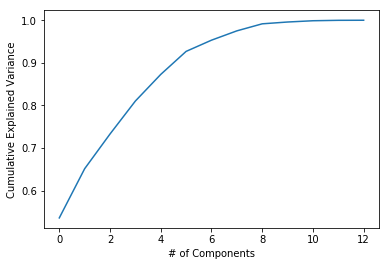

In [19]:
pca_fit = PCA().fit(wr_stan)
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()